In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
28161,HAM_0001152,ISIC_0030133,akiec,histo,65,male,face,False,HAM10000_images_part_2/akiec/ISIC_0030133.jpg,6
1795,HAM_0004510,ISIC_0031110,nv,follow_up,60,male,back,False,HAM10000_images_part_2/nv/ISIC_0031110.jpg,1
10507,HAM_0003348,ISIC_0031799,df,consensus,70,male,lower extremity,False,HAM10000_images_part_2/df/ISIC_0031799.jpg,2
6612,HAM_0007281,ISIC_0034283,bkl,consensus,51,unknown,unknown,False,HAM10000_images_part_2/bkl/ISIC_0034283.jpg,0
2623,HAM_0002162,ISIC_0030708,nv,follow_up,55,female,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0030708.jpg,1


# Preprocessing

**Normalize function**

In [3]:
img_h, img_w = 224, 224

In [4]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

In [5]:
norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

**Data Augmentation and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [6]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [7]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
28161,HAM_0001152,ISIC_0030133,akiec,histo,65,male,face,False,HAM10000_images_part_2/akiec/ISIC_0030133.jpg,6
1795,HAM_0004510,ISIC_0031110,nv,follow_up,60,male,back,False,HAM10000_images_part_2/nv/ISIC_0031110.jpg,1
10507,HAM_0003348,ISIC_0031799,df,consensus,70,male,lower extremity,False,HAM10000_images_part_2/df/ISIC_0031799.jpg,2
6612,HAM_0007281,ISIC_0034283,bkl,consensus,51,unknown,unknown,False,HAM10000_images_part_2/bkl/ISIC_0034283.jpg,0
2623,HAM_0002162,ISIC_0030708,nv,follow_up,55,female,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0030708.jpg,1


**Data Loading**

In [8]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [9]:
batch_size = 64
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


**Batch check**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


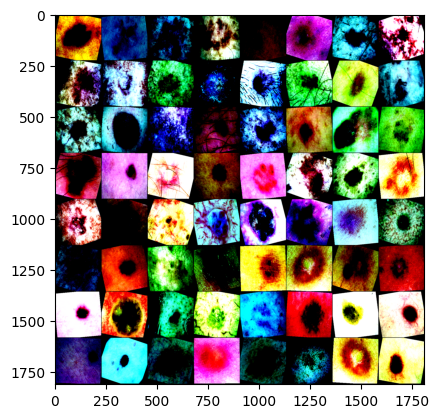

Labels:  tensor([4, 5, 3, 6, 4, 2, 5, 6, 6, 5, 0, 2, 5, 5, 2, 6, 3, 0, 6, 1, 6, 4, 5, 0,
        1, 4, 2, 1, 1, 3, 3, 2, 6, 2, 5, 4, 6, 2, 2, 0, 5, 1, 6, 2, 2, 2, 2, 2,
        1, 0, 5, 6, 5, 1, 0, 4, 4, 1, 0, 2, 5, 0, 2, 4])


In [10]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels) 

# Make the custom model

In [11]:
num_classes = 7

In [14]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(16),            
        nn.ReLU(),            
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))

        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = x.view(-1, 3, img_h, img_w)
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)

        out = out4.view(out4.size(0), -1) #makes them flat
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

CNN_model = CNNet()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [16]:
CNN_model = CNN_model.to(device)
input_size = (3, 224, 224)
summary(CNN_model, input_size, device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 16, 224, 224]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 224, 224]        32
|    └─ReLU: 2-3                         [-1, 16, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 112, 112]        --
├─Sequential: 1-2                        [-1, 32, 56, 56]          --
|    └─Conv2d: 2-5                       [-1, 32, 112, 112]        4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 112, 112]        64
|    └─ReLU: 2-7                         [-1, 32, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 32, 56, 56]          --
├─Sequential: 1-3                        [-1, 64, 28, 28]          --
|    └─Conv2d: 2-9                       [-1, 64, 56, 56]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 56, 56]          128
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 16, 224, 224]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 224, 224]        32
|    └─ReLU: 2-3                         [-1, 16, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 112, 112]        --
├─Sequential: 1-2                        [-1, 32, 56, 56]          --
|    └─Conv2d: 2-5                       [-1, 32, 112, 112]        4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 112, 112]        64
|    └─ReLU: 2-7                         [-1, 32, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 32, 56, 56]          --
├─Sequential: 1-3                        [-1, 64, 28, 28]          --
|    └─Conv2d: 2-9                       [-1, 64, 56, 56]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 56, 56]          128
|    └

In [17]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-3)

**Fit the model using Validation set for the best model selection**

In [16]:
start_time = time.time()

In [17]:
epochs = 25
patience = 3
model_filename = 'CNN_model.pth'
model = CNN_model
CNN_model_fitted, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename)

  4%|▍         | 1/25 [00:50<20:02, 50.10s/it]

Epoch 1
Training Loss: 1.5876084808836277 
Training Accuracy: 41.700372108073125%
Validation Loss: 1.176362510501724 
Validation Accuracy: 57.12667853098204%
Validation Loss Decreased(inf--->1.176363) 
Saving The Model


  8%|▊         | 2/25 [01:39<19:03, 49.70s/it]

Epoch 2
Training Loss: 1.0736383614466363 
Training Accuracy: 59.97411422099984%
Validation Loss: 0.9203975173001436 
Validation Accuracy: 66.00873645041256%
Validation Loss Decreased(1.176363--->0.920398) 
Saving The Model


 12%|█▏        | 3/25 [02:29<18:15, 49.80s/it]

Epoch 3
Training Loss: 0.8903385744113284 
Training Accuracy: 66.24332632260152%
Validation Loss: 0.9201797108674786 
Validation Accuracy: 64.4798576282155%
Validation Loss Decreased(0.920398--->0.920180) 
Saving The Model


 16%|█▌        | 4/25 [03:19<17:31, 50.09s/it]

Epoch 4
Training Loss: 0.77704597072503 
Training Accuracy: 70.52256916356576%
Validation Loss: 0.7643690799007711 
Validation Accuracy: 72.01100145607506%
Validation Loss Decreased(0.920180--->0.764369) 
Saving The Model


 20%|██        | 5/25 [04:10<16:44, 50.25s/it]

Epoch 5
Training Loss: 0.7121001904465488 
Training Accuracy: 73.12732567545704%
Validation Loss: 0.6356006433668825 
Validation Accuracy: 76.00711858922504%
Validation Loss Decreased(0.764369--->0.635601) 
Saving The Model


 24%|██▍       | 6/25 [05:00<15:54, 50.22s/it]

Epoch 6
Training Loss: 0.6301512541537432 
Training Accuracy: 76.20126193172626%
Validation Loss: 0.6863644073150822 
Validation Accuracy: 75.53793884484712%


 28%|██▊       | 7/25 [05:50<14:59, 49.96s/it]

Epoch 7
Training Loss: 0.5738170335895008 
Training Accuracy: 78.83028636143018%
Validation Loss: 0.5212759813389827 
Validation Accuracy: 80.37534379550235%
Validation Loss Decreased(0.635601--->0.521276) 
Saving The Model


 32%|███▏      | 8/25 [06:39<14:05, 49.73s/it]

Epoch 8
Training Loss: 0.5225684526040382 
Training Accuracy: 80.29445073612683%
Validation Loss: 0.4329636630784605 
Validation Accuracy: 84.25012133958906%
Validation Loss Decreased(0.521276--->0.432964) 
Saving The Model


 36%|███▌      | 9/25 [07:29<13:15, 49.73s/it]

Epoch 9
Training Loss: 0.4865657522813561 
Training Accuracy: 81.70198996926064%
Validation Loss: 0.41651223776573987 
Validation Accuracy: 84.80828344928005%
Validation Loss Decreased(0.432964--->0.416512) 
Saving The Model


 40%|████      | 10/25 [08:18<12:23, 49.59s/it]

Epoch 10
Training Loss: 0.40450302711159913 
Training Accuracy: 85.47969584209675%
Validation Loss: 0.3745137748798144 
Validation Accuracy: 86.56366283772853%
Validation Loss Decreased(0.416512--->0.374514) 
Saving The Model


 44%|████▍     | 11/25 [09:08<11:38, 49.87s/it]

Epoch 11
Training Loss: 0.39641967131612227 
Training Accuracy: 85.64957126678532%
Validation Loss: 0.37691885901173366 
Validation Accuracy: 86.8467885455428%


 48%|████▊     | 12/25 [09:59<10:50, 50.03s/it]

Epoch 12
Training Loss: 0.3706049071144812 
Training Accuracy: 86.64455589710403%
Validation Loss: 0.3153550881009126 
Validation Accuracy: 88.88529364180553%
Validation Loss Decreased(0.374514--->0.315355) 
Saving The Model


 52%|█████▏    | 13/25 [10:49<10:02, 50.18s/it]

Epoch 13
Training Loss: 0.32171848877189085 
Training Accuracy: 88.3999352855525%
Validation Loss: 0.36001812920127946 
Validation Accuracy: 87.58291538585989%


 56%|█████▌    | 14/25 [11:40<09:12, 50.21s/it]

Epoch 14
Training Loss: 0.2952367609232357 
Training Accuracy: 89.59715256430998%
Validation Loss: 0.2721062640169847 
Validation Accuracy: 90.40608315806504%
Validation Loss Decreased(0.315355--->0.272106) 
Saving The Model


 60%|██████    | 15/25 [12:29<08:20, 50.05s/it]

Epoch 15
Training Loss: 0.28947152423950817 
Training Accuracy: 89.7751172949361%
Validation Loss: 0.28328378005049276 
Validation Accuracy: 90.05015369681281%


 64%|██████▍   | 16/25 [13:19<07:29, 49.92s/it]

Epoch 16
Training Loss: 0.26744041787748485 
Training Accuracy: 90.35754732243973%
Validation Loss: 0.27791630879966256 
Validation Accuracy: 90.42226176994014%


 68%|██████▊   | 17/25 [14:09<06:40, 50.08s/it]

Epoch 17
Training Loss: 0.25651497912314747 
Training Accuracy: 90.87526290244297%
Validation Loss: 0.2608930749684265 
Validation Accuracy: 91.09367416275684%
Validation Loss Decreased(0.272106--->0.260893) 
Saving The Model


 72%|███████▏  | 18/25 [15:00<05:51, 50.19s/it]

Epoch 18
Training Loss: 0.22379494604376174 
Training Accuracy: 91.918783368387%
Validation Loss: 0.25255160834448237 
Validation Accuracy: 91.36871056463356%
Validation Loss Decreased(0.260893--->0.252552) 
Saving The Model


 76%|███████▌  | 19/25 [15:49<04:59, 49.89s/it]

Epoch 19
Training Loss: 0.23004112406105726 
Training Accuracy: 91.85406892088659%
Validation Loss: 0.2536113667157815 
Validation Accuracy: 91.28781750525805%


 80%|████████  | 20/25 [16:39<04:09, 49.88s/it]

Epoch 20
Training Loss: 0.21145325503552082 
Training Accuracy: 92.71153535026694%
Validation Loss: 0.19244224817213632 
Validation Accuracy: 93.48001941433425%
Validation Loss Decreased(0.252552--->0.192442) 
Saving The Model


 84%|████████▍ | 21/25 [17:29<03:19, 49.98s/it]

Epoch 21
Training Loss: 0.19498173652466425 
Training Accuracy: 93.22116162433264%
Validation Loss: 0.18316911687095142 
Validation Accuracy: 94.03009221808769%
Validation Loss Decreased(0.192442--->0.183169) 
Saving The Model


 88%|████████▊ | 22/25 [18:18<02:29, 49.75s/it]

Epoch 22
Training Loss: 0.2122147255721166 
Training Accuracy: 92.35560588901473%
Validation Loss: 0.20216841734561725 
Validation Accuracy: 93.15644717683223%


 92%|█████████▏| 23/25 [19:07<01:38, 49.49s/it]

Epoch 23
Training Loss: 0.16780678351822587 
Training Accuracy: 93.98155638246239%
Validation Loss: 0.20663990981915256 
Validation Accuracy: 92.95421452839346%


100%|██████████| 25/25 [19:57<00:00, 47.90s/it]

Epoch 24
Training Loss: 0.19661785948291882 
Training Accuracy: 93.00275036401877%
Validation Loss: 0.20341464619814736 
Validation Accuracy: 93.64180553308526%


-------------------------------------------------------
Best models accuracy 93.73887720433586
-------------------------------------------------------


In [18]:
end_time = time.time()

In [19]:
total_time = end_time - start_time
print(f"Total training and validation time for our Model: {total_time/60:.2f} minutes")

Total training and validation time for our Model: 1210.13 seconds


In [20]:
# # Test the model
# test_accuracy = test_model(CNN_model_fitted, test_loader, device)
# print('-------------------------------------------------------')
# print(f'Best models accuracy {test_accuracy}')
# print('-------------------------------------------------------')

NameError: name 'total_loss_train' is not defined

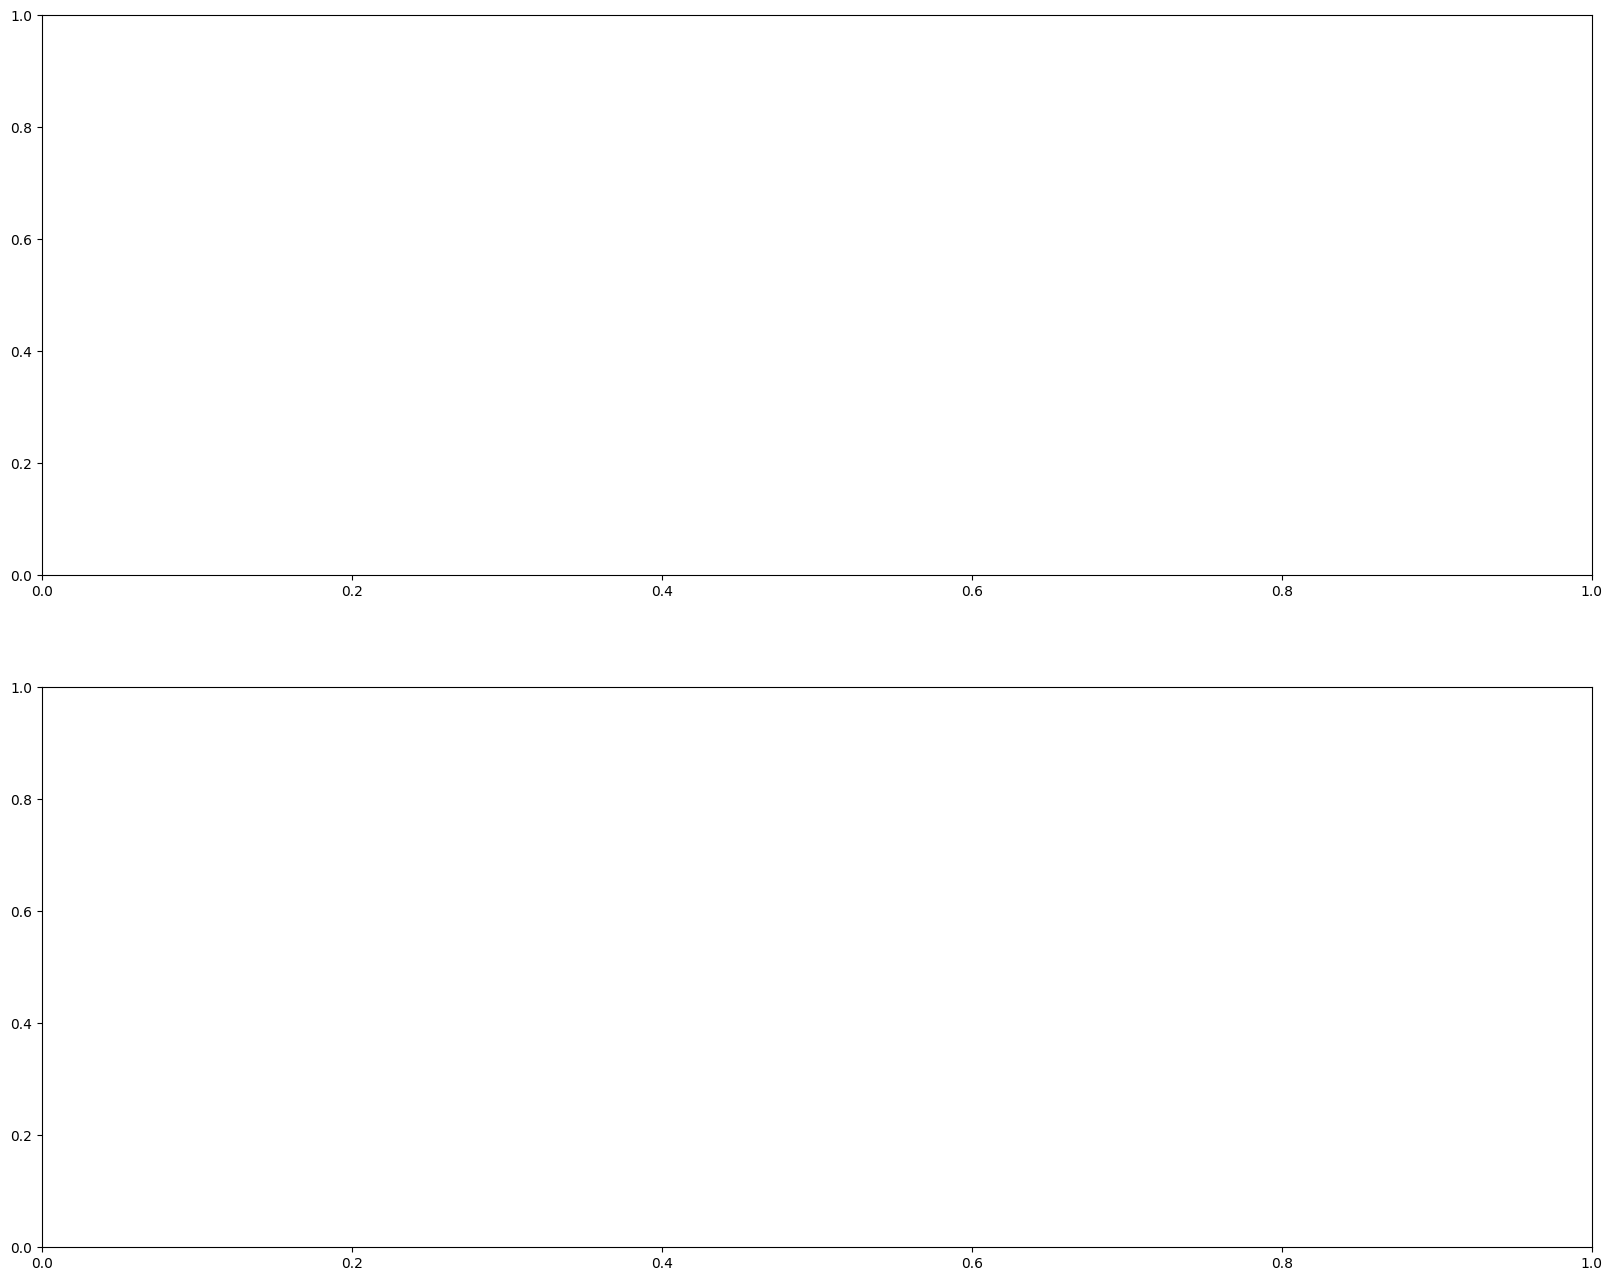

In [22]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss for our model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_title('Accuracy for our model', fontsize=14)  
fig2.legend()
plt.show()

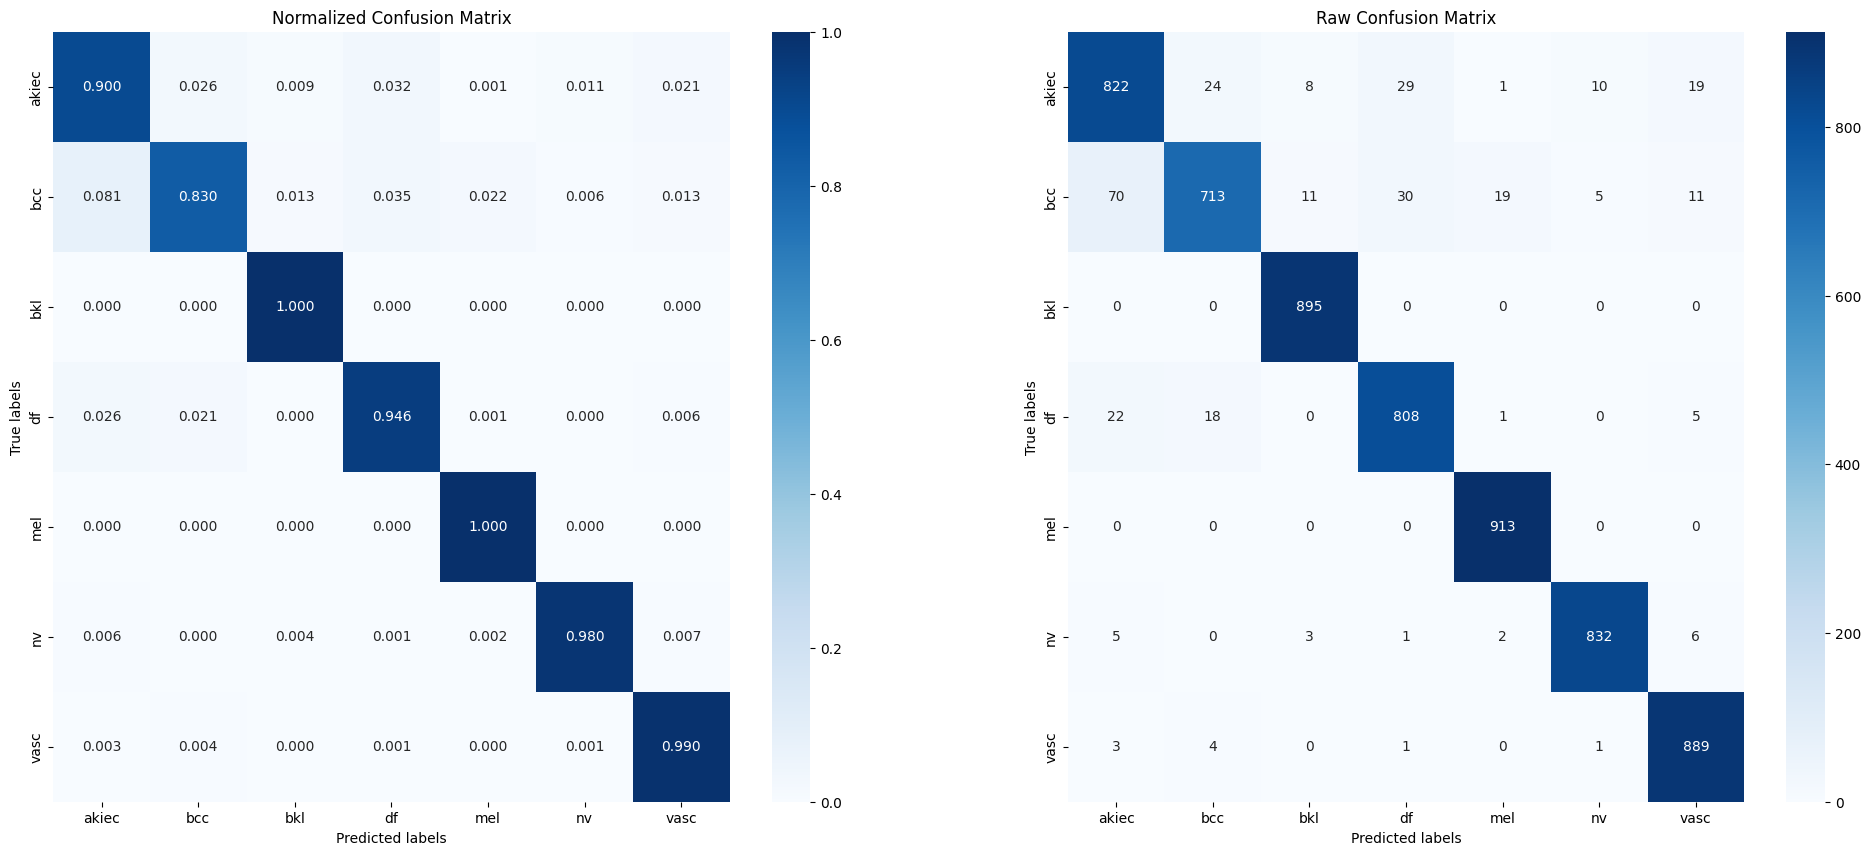

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

       akiec       0.89      0.90      0.90       913
         bcc       0.94      0.83      0.88       859
         bkl       0.98      1.00      0.99       895
          df       0.93      0.95      0.94       854
         mel       0.98      1.00      0.99       913
          nv       0.98      0.98      0.98       849
        vasc       0.96      0.99      0.97       898

    accuracy                           0.95      6181
   macro avg       0.95      0.95      0.95      6181
weighted avg       0.95      0.95      0.95      6181

-------------------------------------------------------


In [23]:
Model_functions.conf_report(CNN_model, test_loader, 'CNN_from_scratch', device)

In [19]:
# Test the model
best_model_state = torch.load('CNN_model.pth')
CNN_model_fitted.load_state_dict(best_model_state)
test_accuracy = Model_functions.test_model(CNN_model_fitted, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 94.43455751496522
-------------------------------------------------------
